# HW 3: CNN for Image and Text Classification

In this assignment, we'll have two experiments:
- Image classification: Diagnose COVID-19 by CT images
- Text classification: Let's redo the news classification task of HW #2 using CNN

## Q1: Diagnose COVID-19 by CT images (7 points)

Please first download the CT images
- `COVID-19 CT scans`: https://github.com/UCSD-AI4H/COVID-CT/blob/master/Images-processed/CT_COVID.zip. In total, there are 349 images.
- `Non-COVID-19 Scans`: https://github.com/UCSD-AI4H/COVID-CT/blob/master/Images-processed/CT_NonCOVID.zip. There are 397 images in total.

This dataset may be a little small for CNN models. Let's just use this dataset to practice CNN models.

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! wget https://github.com/UCSD-AI4H/COVID-CT/blob/master/Images-processed/CT_COVID.zip

--2021-11-02 01:45:23--  https://github.com/UCSD-AI4H/COVID-CT/blob/master/Images-processed/CT_COVID.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘CT_COVID.zip’

CT_COVID.zip            [ <=>                ] 137.03K  --.-KB/s    in 0.08s   

2021-11-02 01:45:23 (1.76 MB/s) - ‘CT_COVID.zip’ saved [140323]



In [ ]:
!wget  https://github.com/UCSD-AI4H/COVID-CT/blob/master/Images-processed/CT_NonCOVID.zip

--2021-11-02 01:45:23--  https://github.com/UCSD-AI4H/COVID-CT/blob/master/Images-processed/CT_NonCOVID.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘CT_NonCOVID.zip’

CT_NonCOVID.zip         [ <=>                ] 131.98K  --.-KB/s    in 0.08s   

2021-11-02 01:45:24 (1.68 MB/s) - ‘CT_NonCOVID.zip’ saved [135148]



### Q1.1. Data Preprocessing (1 point)

- Refer to CNN labs to read the image files and create datasets.
- For each class, use 60% images for training, 20% for validation, and 20% for testing. The split has been created for you.
- Create a Dataset class so that you can preprocess images and generate mini-batches for training. Since the CT scans are grayscale (only 1 channel), you can transform all images to grayscale. 

In [6]:
! pip install torchinfo

In [7]:
import os
import glob
import sklearn
import concurrent
import numpy as np
from PIL import Image
import zipfile
import shutil
import random


os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# add your import here
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Dataset
from torchinfo import summary

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [8]:
# set random seed to so that work can be replicated

random_seed = 124
np.random.seed(random_seed)

torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# load data and split data to train, evaluation and test
# cur_path = "/content/drive/MyDrive/BIA_667_Intro_DL/assignments/assignment3"
cur_path = "/content/drive/MyDrive/BIA-667/assignment3"
pos_files = [f for f in glob.glob(os.path.join(cur_path, 'CT_COVID','*.*'))]
neg_files = [f for f in  glob.glob(os.path.join(cur_path, 'CT_NonCOVID','*.*'))]

images = pos_files + neg_files
labels = np.array([1]*len(pos_files)+[0]*len(neg_files))

images_tv, images_test, y_tv, y_test  = train_test_split(images, labels, shuffle=True, test_size=0.2, random_state=123)
images_train, images_val, y_train, y_val  = train_test_split(images_tv, y_tv, shuffle=True, test_size=0.25, random_state=123)

In [12]:
print(len(y_train), len(y_val), len(y_test))

print(y_train.sum(), y_val.sum(), y_test.sum())

447 149 150
207 71 71


In [11]:
pos_files[0]

'/content/drive/MyDrive/BIA-667/assignment3/CT_COVID/2020.03.04.20031047-p13-84_2.png'

In [13]:
# create Dataset class

class CT_Dataset(Dataset):
    def __init__(self, img_path, img_labels, img_transforms=None):
        self.img_path = img_path
        self.img_labels = torch.Tensor(img_labels)
        # if img_transforms is None:
        #     self.transforms = transforms.ToTensor()
        # else:
        self.transforms = img_transforms
    
    def __getitem__(self, index):
        cur_path = self.img_path[index] 
        cur_img = Image.open(cur_path).convert('RGB')
        cur_img = self.transforms(cur_img)
        return cur_img, self.img_labels[index]
    
    def __len__(self):
        return len(self.img_path)
    

In [14]:
resize_transforms = transforms.Compose([
                                        transforms.Resize((255, 255)),
                                        transforms.Grayscale(num_output_channels=1), 
                                        transforms.ToTensor()
                                        ])

In [20]:
# images_train, images_val, y_train, y_val
train_data = CT_Dataset(images_train, y_train, img_transforms=resize_transforms)
test_data = CT_Dataset(images_val, y_val, img_transforms=resize_transforms) 

### Q1.2. Build Model (2 points)

- Create a CNN models with appropriate layers of `Convolution`, `MaxPooling2D`, and `Dense` layers. Use appropriate activation functions for these layers.
- Since this dataset is small, it may be easily get overfitted. Leverage `Dropout` or other regularization techniques to fight overfitting
- Configure your model with appropriate optimizer and loss function.

In [15]:
# define CNN mode

class Convnet(nn.Module):
    def __init__(self, dropout_ratio=0.3):
        super(Convnet, self).__init__()
        # conv net 1, 150, 150 
        self.convnet = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),  
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5),  # (64, 3, 3)
            nn.Flatten() # 64*3*3 features after flattening 
        )
        # classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_ratio),
            nn.Linear(in_features=468512, out_features=64),  # 576 = 64 * 3 * 3
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=1)
        )
    def forward(self, x):
        x = self.convnet(x)
        x = self.classifier(x)

        return x

In [16]:
visual_model = Convnet()
print(visual_model)

Convnet(
  (convnet): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=468512, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


### Q1.3. Fit your model (2 points)

- Define a function to train the model until it converges. You should use the `evaluation dataset` to control the training process such that the model is not overfitted.
- Plot the loss and accuracy of the model over the training and validation data
- Test the model using `test dataset` and show the test accuracy. If everything goes well, the test accuracy should be 65% or higher

In [126]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            # self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [125]:
# define training function

def train_model(model, train_dataset, test_dataset, device, 
                lr=0.0001, epochs=30, batch_size=32):
    # construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # move model to device
    model = model.to(device)
    early_stopping = EarlyStopping(patience=5, verbose=True)

    # history
    history = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}
    # setup loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # training loop
    print('Training Starts ')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        
        for x, y in train_loader:
            # move data to device
            # print("what the")
            x = x.to(device)
            y = y.to(device)
            # forward
            outputs = model(x).view(-1)  # (num_batch)
            # print(outputs.shape)
            # print(y.shape)
            cur_train_loss = criterion(outputs, y)
            pred = torch.sigmoid(outputs)
            pred = torch.round(pred)
            cur_train_acc = (pred == y).sum().item() / batch_size
            # backward
            cur_train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # loss and acc
            train_loss += cur_train_loss
            train_acc += cur_train_acc

        # test start
        model.eval()
        with torch.no_grad():
            for x, y in test_loader:
                # move
                x = x.to(device)
                y = y.to(device)
                # predict
                outputs = model(x).view(-1)
                pred = torch.round(torch.sigmoid(outputs))
                cur_test_loss = criterion(outputs, y)
                cur_test_acc = (pred == y).sum().item() / batch_size 
                # loss and acc
                test_loss += cur_test_loss
                test_acc += cur_test_acc

        # epoch output
        train_loss = (train_loss/len(train_loader)).item()
        train_acc = train_acc/len(train_loader)
        val_loss = (test_loss/len(test_loader)).item()
        val_acc = test_acc/len(test_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(val_loss)
        history['test_acc'].append(val_acc)
        print(f"Epoch:{epoch + 1} / {epochs}, train loss:{train_loss:.4f} train_acc:{train_acc:.4f}, valid loss:{val_loss:.4f} valid acc:{val_acc:.4f}")

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    
    return history
    

In [28]:
# Train the CNN model

cnn_model = Convnet(dropout_ratio=0.4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
history = train_model(cnn_model, train_data, test_data, device, batch_size=32, epochs=300, lr=0.00001)

Training Starts 
Epoch:1 / 300, train loss:0.6907 train_acc:0.5402, valid loss:0.6745 valid acc:0.5500
Validation loss decreased (inf --> 0.674521).  Saving model ...
Epoch:2 / 300, train loss:0.6636 train_acc:0.6116, valid loss:0.6544 valid acc:0.6125
Validation loss decreased (0.674521 --> 0.654359).  Saving model ...
Epoch:3 / 300, train loss:0.6457 train_acc:0.6540, valid loss:0.6431 valid acc:0.5625
Validation loss decreased (0.654359 --> 0.643136).  Saving model ...
Epoch:4 / 300, train loss:0.6480 train_acc:0.6473, valid loss:0.6348 valid acc:0.6312
Validation loss decreased (0.643136 --> 0.634761).  Saving model ...
Epoch:5 / 300, train loss:0.6226 train_acc:0.6629, valid loss:0.6216 valid acc:0.6500
Validation loss decreased (0.634761 --> 0.621642).  Saving model ...
Epoch:6 / 300, train loss:0.5943 train_acc:0.7031, valid loss:0.6433 valid acc:0.5625
EarlyStopping counter: 1 out of 5
Epoch:7 / 300, train loss:0.6021 train_acc:0.6696, valid loss:0.6269 valid acc:0.6000
EarlySt

Text(0.5, 1.0, 'Loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

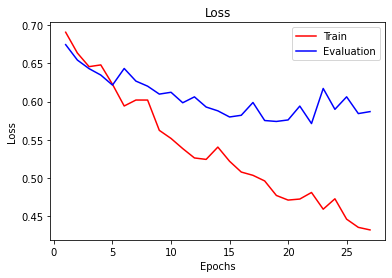

Text(0.5, 1.0, 'Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Acc')

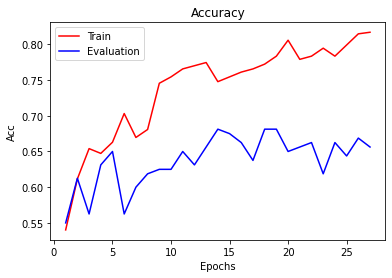

In [29]:
# plot training curves

epochs = range(1, len(history['train_loss']) + 1)

plt.plot(epochs, history['train_loss'], 'r-', label='Train')
plt.plot(epochs, history['test_loss'], 'b-', label='Evaluation')

plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, history['train_acc'], 'r-', label='Train')
plt.plot(epochs, history['test_acc'], 'b-', label='Evaluation')

plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

### Q1.4. Using data augmentation (2 points)

Since we have a small dataset, a thought is that perhaps we can improve the performance by data augmentation


- Modify your Dataset class to add appropriate data augumentation. Check the augmentation techniques here: https://pytorch.org/vision/stable/transforms.html
- Try 2 augmentation techniques to see if this can improve model performance on testing
- Note that CT scans usually are well positioned. Just try minor adjustment without unrealistic changes to images. 

- Repeat Task 1.3 with the augmented data 

- For this CT image dataset, it is not guranteed that augmentation may help. Just give a try and anazye why your augmentation techniques may (or may not) help.

In [129]:
# add augmentation
# train the model with augmented data


data_augmentation = transforms.Compose([transforms.Grayscale(num_output_channels=1), 
                                        transforms.RandomRotation(5),
                                        transforms.RandomHorizontalFlip(p=0.5),
                                        # transforms.RandomAffine(degrees=(-20,20), translate=(0, 0.3)),
                                        # transforms.RandomVerticalFlip(p=0.5),
                                        transforms.Resize((255, 255)),  
                                        transforms.ToTensor()
                                        ])
train_data = CT_Dataset(images_train, y_train, img_transforms=data_augmentation)
test_data = CT_Dataset(images_val, y_val, img_transforms=data_augmentation) 

In [130]:
# Train the CNN model
cnn_model = Convnet()
history = train_model(cnn_model, train_data, test_data, device, batch_size=32, epochs=100, lr=0.00001)

Training Starts 
Epoch:1 / 100, train loss:0.6999 train_acc:0.5357, valid loss:0.6716 valid acc:0.5750
Epoch:2 / 100, train loss:0.6700 train_acc:0.5804, valid loss:0.6539 valid acc:0.5875
Validation loss decreased (inf --> 0.653925).  Saving model ...
Epoch:3 / 100, train loss:0.6487 train_acc:0.6562, valid loss:0.6437 valid acc:0.5813
Validation loss decreased (0.653925 --> 0.643676).  Saving model ...
Epoch:4 / 100, train loss:0.6363 train_acc:0.6272, valid loss:0.6267 valid acc:0.6687
Validation loss decreased (0.643676 --> 0.626662).  Saving model ...
Epoch:5 / 100, train loss:0.6316 train_acc:0.6429, valid loss:0.6217 valid acc:0.5938
Validation loss decreased (0.626662 --> 0.621694).  Saving model ...
Epoch:6 / 100, train loss:0.6193 train_acc:0.6562, valid loss:0.6127 valid acc:0.6188
Validation loss decreased (0.621694 --> 0.612669).  Saving model ...
Epoch:7 / 100, train loss:0.6087 train_acc:0.6518, valid loss:0.6064 valid acc:0.6188
Validation loss decreased (0.612669 --> 0

In [ ]:
# without augmentation: Epoch:27 / 300, train loss:0.4323 train_acc:0.8170, valid loss:0.5869 valid acc:0.6562
# with data augmentation: all three Epoch:27 / 100, train loss:0.5112 train_acc:0.7522, valid loss:0.6095 valid acc:0.6188


## Data augmentation analysis

Without applying any data augmentation methods the performance of the model is as follows 
   - Epoch:27 / 300, train loss:0.4323 train_acc:0.8170, valid loss:0.5869 valid acc:0.6562

I have applied the following data augmentation methods on the given dataset and recorded the accuracies 

- transforms.RandomHorizontalFlip(p=0.5) : Horizontally flip the given image randomly with a given probability. 
- transforms.RandomRotation(5) : Rotate the image by angle. 
- transforms.Resize : Resize the input image to the given size. 

Applying all the three augnemtation methods the performance of the model is as follows
   - Epoch:39 / 100, train loss:0.4716 train_acc:0.7656, valid loss:0.5366 valid acc:0.6750

### My observation
- By horizontally flipping and by randomly rotating the images, I have tried to reposition the images which has exposed the models to a different location of the image which has resulted in the model perform well on unseen dataset 
- I believe the techniques are also helping in fighting the overfighting problem in this case
- we can increase the performance of the model by applying the above three data augmentation methods. In this case as we can see the validation accuracy has increased from 0.6562 to 0.6750. The same can also be confirmed with the help of the plots
- so in this case the augmentation techniques helped achieve an improved performance of the model 




Text(0.5, 1.0, 'Loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

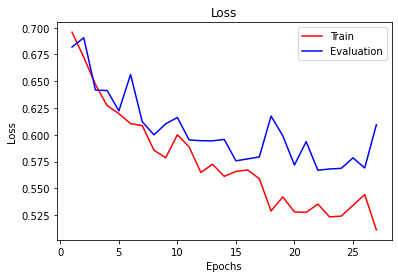

Text(0.5, 1.0, 'Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Acc')

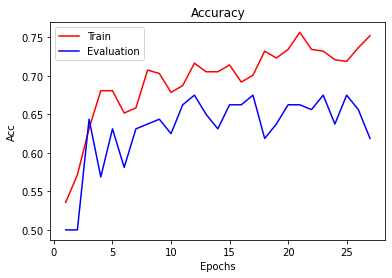

In [40]:
# plot training curves

epochs = range(1, len(history['train_loss']) + 1)

plt.plot(epochs, history['train_loss'], 'r-', label='Train')
plt.plot(epochs, history['test_loss'], 'b-', label='Evaluation')

plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, history['train_acc'], 'r-', label='Train')
plt.plot(epochs, history['test_acc'], 'b-', label='Evaluation')

plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

## Q2: News Classification by CNN (3 points)

In HW #2, You have used linear layers to classify text. This time, let's use CNN model to see if the performance can be improved.



### Q2.1 Data Processing (1 point)

Since the embedding layer expects a sentences with uniform length, you need to pad or truncate the sentences to the same length. Properly decide the maximum length of the sentence so that most of sentences are kept intact after processing. However, do not set the maximum length too big, which reduces the computational efficiency.

In [41]:
import keras
from keras.datasets import reuters
import pandas as pd

In [42]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

# show the sizes training/testing samples 
len(train_data)
len(test_data)

# show an example from the training dataset
print(train_data[10])

# retrieve the mapping from words to indices
word_index = reuters.get_word_index()

# reverse mapping
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index[i - 3] for i in train_data[0] if (i-3) in reverse_word_index])

decoded_newswire

2121728/2110848 [==============================] - 0s 0us/step


8982

2246

[1, 245, 273, 207, 156, 53, 74, 160, 26, 14, 46, 296, 26, 39, 74, 2979, 3554, 14, 46, 4689, 4329, 86, 61, 3499, 4795, 14, 61, 451, 4329, 17, 12]
565248/550378 [==============================] - 0s 0us/step


'said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [43]:
# distribution of labels

len(pd.Series(train_labels).value_counts())


46

(array([7.619e+03, 9.870e+02, 2.890e+02, 7.900e+01, 5.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([  13. ,  249.3,  485.6,  721.9,  958.2, 1194.5, 1430.8, 1667.1,
        1903.4, 2139.7, 2376. ]),
 <a list of 10 Patch objects>)

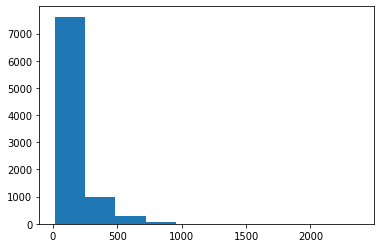

In [44]:
# visualize 
from matplotlib import pyplot as plt
plt.hist ([len(doc) for doc in train_data])
plt.show()

In [80]:
# Pad or truncate sentences so that they have uniform length
# every sentence is 500 or less
DOC_LEN = 500

# convert numpy array to list
train_x = train_data.tolist()
test_x = test_data.tolist()

# truncate & padding function
def truncate_or_pad(doc):
    if len(doc) < DOC_LEN:
        doc += [0] * (DOC_LEN - len(doc))
    else:
        doc = doc[:DOC_LEN]
    return doc


In [81]:
train_x = list(map(truncate_or_pad, train_x))
test_x = list(map(truncate_or_pad, test_x))
#verify
print('Train:')
print(f"Max length: {max([len(sequence) for sequence in train_x])}")
print(f"Min length: {min([len(sequence) for sequence in train_x])}")
print('Test:')
print(f"Max length: {max([len(sequence) for sequence in test_x])}")
print(f"Min length: {min([len(sequence) for sequence in test_x])}")

Train:
Max length: 500
Min length: 500
Test:
Max length: 500
Min length: 500


In [82]:
# convert labels to float
# as model needs float values
# cross entropy function expects labels are floats
# Yt_train = Yt_train.type(torch.LongTensor)
train_y = np.asarray(train_labels).astype('float')
test_y = np.asarray(test_labels).astype('float')

In [83]:
# add your code to create Dataset class
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
class news_dataset(Dataset):
    def __init__(self, featuers, labels):
        self.length = len(labels)
        self.features = torch.IntTensor(featuers)
        self.labels = torch.Tensor(labels).type(torch.LongTensor)
    
    def __getitem__(self, index):
        return self.features[index], self.labels[index]
    
    def __len__(self):
        return self.length  


In [84]:
train_dataset = news_dataset(train_x, train_y)
test_dataset = news_dataset(test_x, test_y)

### Q2.2 Define the model (2 points)

- Your model should contain the follow layers:
    - Embedding (Note, you are not required to use pretrained word vector in the embedding layer in this task)
    - Convolution
    - MaxPool
    - Flatten, Concatenate, Dropout if needed
    - Dense


- Carefully choose the following hyperparameters:
  - Max. sentence length
  - Embedding dimension
  - Filter sizes and number of filters 
- Use appropriate activate functions for all layers

In [85]:
class cnn_text(nn.Module):
    def __init__(self, num_words_in_dict, embedding_dim, dropout_ratio):
        super(cnn_text, self).__init__()
        self.num_words_in_dict = num_words_in_dict
        self.embedding_dim = embedding_dim
        self.dropout_ratio = dropout_ratio
        # embedding
        self.embedding = nn.Embedding(num_embeddings=num_words_in_dict, embedding_dim=embedding_dim)  # (-1, DOC_LEN, embedding_dim), num_embedding: embedding dict size, embedding_dim: length of embedding vector
        # 1D CNN
        # unigram
        self.unigram = nn.Sequential(# input (-1, embedding_dim, DOC_LEN)
        nn.Conv1d(in_channels=embedding_dim, out_channels=64, kernel_size=1),  # (-1, 64, DOC_LEN)
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=DOC_LEN),  # (-1, 64, 1)
        nn.Flatten()  # (-1, 64 * 1)
        )
        # bigram
        self.bigram = nn.Sequential(# input (-1, embedding_dim, DOC_LEN)
        nn.Conv1d(in_channels=embedding_dim, out_channels=64, kernel_size=2),  # (-1, 64, DOC_LEN-2+1) ??? why DOC_LEN - 2 + 1
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=DOC_LEN - 2 + 1),  # (-1, 64, 1)
        nn.Flatten()  # (-1, 64 * 1)
        )
        # trigram
        self.trigram = nn.Sequential(# input (-1, embedding_dim, DOC_LEN)
        nn.Conv1d(in_channels=embedding_dim, out_channels=64, kernel_size=3),  # (-1, 64, DOC_LEN-3+1)
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=DOC_LEN - 3 + 1),  # (-1, 16, 7)
        nn.Flatten()  # (-1, 64 * 1)
        )
        # simple classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_ratio),
            nn.Linear(in_features=64*3, out_features=46)
        )
    def forward(self, x):
        # get embedding
        x = self.embedding(x)
        # make sure we are convolving on each word
        x = torch.transpose(x, dim0=1, dim1=2)  # (-1, DOC_LEN, embedding_dim): embedding on 1(DOC_LEN) & 2(embedding_dim) dims
        # 1d cnn output
        uni_gram_output = self.unigram(x)
        bi_gram_output = self.bigram(x)
        tri_gram_output = self.trigram(x)
        # concatenate
        x = torch.cat((uni_gram_output, bi_gram_output, tri_gram_output), dim=1)
        # classifier
        # print("frommodels", x.shape)
        x = self.classifier(x)

        return x

In [86]:
visual_model = cnn_text(num_words_in_dict=10000, embedding_dim=100, dropout_ratio=0.3)
print(visual_model)

cnn_text(
  (embedding): Embedding(10000, 100)
  (unigram): Sequential(
    (0): Conv1d(100, 64, kernel_size=(1,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=500, stride=500, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (bigram): Sequential(
    (0): Conv1d(100, 64, kernel_size=(2,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=499, stride=499, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (trigram): Sequential(
    (0): Conv1d(100, 64, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=498, stride=498, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=192, out_features=46, bias=True)
  )
)


### Q2.3. Train the model

- Fit the model, plot the training curve on training and testing datasets

- You can certainly reuse your training function from HW #2.

In [87]:
def train_model(model, train_dataset, test_dataset, device, 
                lr=0.0002, epochs=30, batch_size=64):
    
    # add your code here
        # construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    # move model to device
    model = model.to(device)

    # history
    history = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}

    # setup loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)

    # training loop
    print('Training Start')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        for x, y in train_loader:
            # move data to device
            x = x.to(device)
            y = y.to(device)
            # forward
            outputs = model(x)
            # print("outputs", outputs.shape)
            # print("y", y.shape)
            cur_train_loss = criterion(outputs, y)
            _, pred = torch.max(outputs, dim=-1) # pick the one with max probabilty
            
            cur_train_acc = (pred == y).sum().item() / batch_size
            # backward
            cur_train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # loss and acc
            train_loss += cur_train_loss
            train_acc += cur_train_acc

        # test start
        model.eval()
        with torch.no_grad():
            for x, y in test_loader:
                # move
                x = x.to(device)
                y = y.to(device)
                # predict
                outputs = model(x)
                _, pred = torch.max(outputs, dim=-1)
                
                cur_test_loss = criterion(outputs, y)
                cur_test_acc = (pred == y).sum().item() / batch_size 
                # loss and acc
                test_loss += cur_test_loss
                test_acc += cur_test_acc

        # epoch output
        train_loss = (train_loss/len(train_loader)).item()
        train_acc = train_acc/len(train_loader)
        val_loss = (test_loss/len(test_loader)).item()
        val_acc = test_acc/len(test_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(val_loss)
        history['test_acc'].append(val_acc)
        print(f"Epoch:{epoch + 1} / {epochs}, train loss:{train_loss:.5f} train_acc:{train_acc:.5f}, valid loss:{val_loss:.5f} valid acc:{val_acc:.5f}")
    
    return history

In [88]:
# set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [89]:
# embedding = 200, doc len = 500 : Epoch:30 / 30, train loss:0.68596 train_acc:0.81426, valid loss:0.83800 valid acc:0.78212
# embedding = 200, doc len = 400 : Epoch:30 / 30, train loss:0.68463 train_acc:0.81987, valid loss:0.84991 valid acc:0.77517
# embedding = 100, doc len = 500 : Epoch:30 / 30, train loss:0.90423 train_acc:0.76375, valid loss:0.95922 valid acc:0.75130

# embedding = 100, doc len = 500 : Epoch:100 / 100, train loss:0.45382 train_acc:0.86653, valid loss:0.76530 valid acc:0.79340
# embedding = 200, doc len = 500 : Epoch:100 / 100, train loss:0.26517 train_acc:0.91054, valid loss:0.80211 valid acc:0.79948 

In [96]:
# add code to train the model
model = cnn_text(num_words_in_dict=10000, embedding_dim=200, dropout_ratio=0.3)
history = train_model(model=model,
                      train_dataset=train_dataset,
                      test_dataset=test_dataset,
                      device=device,
                      lr=0.0002,
                      epochs=100,
                      batch_size=128)

Training Start
Epoch:1 / 100, train loss:2.06239 train_acc:0.48019, valid loss:1.74079 valid acc:0.55556
Epoch:2 / 100, train loss:1.72400 train_acc:0.57779, valid loss:1.58260 valid acc:0.63238
Epoch:3 / 100, train loss:1.56833 train_acc:0.62247, valid loss:1.48150 valid acc:0.65321
Epoch:4 / 100, train loss:1.46342 train_acc:0.64987, valid loss:1.40715 valid acc:0.66710
Epoch:5 / 100, train loss:1.37859 train_acc:0.66824, valid loss:1.32680 valid acc:0.68099
Epoch:6 / 100, train loss:1.32185 train_acc:0.67881, valid loss:1.26843 valid acc:0.69054
Epoch:7 / 100, train loss:1.26490 train_acc:0.69707, valid loss:1.22933 valid acc:0.69922
Epoch:8 / 100, train loss:1.18402 train_acc:0.70863, valid loss:1.18753 valid acc:0.70269
Epoch:9 / 100, train loss:1.15695 train_acc:0.71490, valid loss:1.14073 valid acc:0.71267
Epoch:10 / 100, train loss:1.12036 train_acc:0.72898, valid loss:1.12049 valid acc:0.71962
Epoch:11 / 100, train loss:1.07438 train_acc:0.73250, valid loss:1.07947 valid acc:0

Text(0.5, 1.0, 'Loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

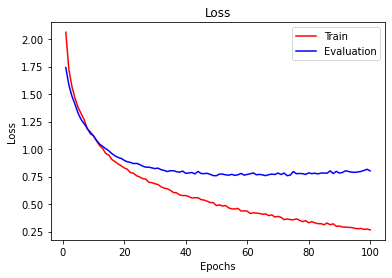

Text(0.5, 1.0, 'Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Acc')

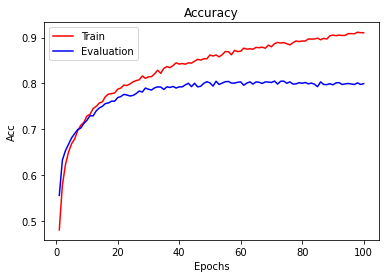

In [97]:
# show training curve

epochs = range(1, len(history['train_loss']) + 1)

plt.plot(epochs, history['train_loss'], 'r-', label='Train')
plt.plot(epochs, history['test_loss'], 'b-', label='Evaluation')

plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, history['train_acc'], 'r-', label='Train')
plt.plot(epochs, history['test_acc'], 'b-', label='Evaluation')

plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

### Q2.4 (Bonus) Pretrained Wore Vectors (2 points)

It's a common practice to use pretrained word vectors to initialize the embedding layer paramters and then fine tune (or freeze) the embedding layer during model training.

- Train word vector by yourself or find pretrained word vectors
- Initialize the embedding layer with the word vectors
- You can freeze the embedding layer or fine tune the layer
- Fit the model to see what strategy can further improve the training performance
- You're expected to show at least 1% improvement from Q2.3. in terms of test accuracy.

In [98]:
! pip install --upgrade gensim  &> /dev/null # install gensim 4.0.0 on colab

In [99]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10100)
# word_index is a dictionary mapping words to an integer index
word_index = reuters.get_word_index()

print(train_data[10] , train_labels[10])

len(word_index)

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

print(len(train_data), len(train_labels))
print(len(test_data), len(test_labels))



[1, 245, 273, 207, 156, 53, 74, 160, 26, 14, 46, 296, 26, 39, 74, 2979, 3554, 14, 46, 4689, 4329, 86, 61, 3499, 4795, 14, 61, 451, 4329, 17, 12] 3


30979

8982 8982
2246 2246


In [100]:
# get doc list
doc_list = []
for cur_sentence in np.concatenate((train_data, test_data)):
    sentence_list = []
    for cur_word_index in cur_sentence:
        cur_word = reverse_word_index.get(cur_word_index - 3)
        if cur_word:
            sentence_list.append(cur_word)
    doc_list.append(sentence_list)
# concat labels
doc_labels = np.concatenate((train_labels, test_labels))

['period',
 'ended',
 'december',
 '31',
 'shr',
 'profit',
 '11',
 'cts',
 'vs',
 'loss',
 '24',
 'cts',
 'net',
 'profit',
 '224',
 '271',
 'vs',
 'loss',
 '511',
 '349',
 'revs',
 '7',
 '258',
 '688',
 'vs',
 '7',
 '200',
 '349',
 'reuter',
 '3']

(array([7093.,  280., 1024.,  651., 1256.,  289.,  209.,  131.,  178.,
         117.]),
 array([ 0. ,  4.5,  9. , 13.5, 18. , 22.5, 27. , 31.5, 36. , 40.5, 45. ]),
 <a list of 10 Patch objects>)

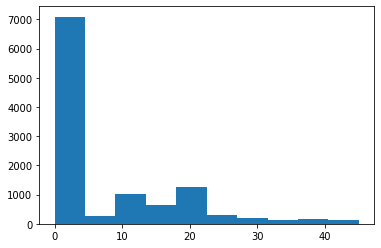

In [ ]:
doc_list[10]
from matplotlib import pyplot as plt
plt.hist(doc_labels)

### Train word2vec model with Gensim

In [101]:
from gensim.models import word2vec
def train_word2vec(corpus, size, window, min_count, epochs, sg, workers, save):
  model = word2vec.Word2Vec(corpus, 
                            vector_size=size,   # embedding vector size
                            window=window,   # text window in word2vec
                            min_count=min_count,  # minimal times of apperence to take into consideration
                            epochs=epochs,  # train model with epochs
                            sg=sg, # 1 for skip-gram; otherwise CBOW.
                            workers=workers,  # number of threads for training
                            )
  print('Done')
  if save:
    print('Saving:')
    model.save(os.path.join(cwd_path, 'word2vec.model'))
    print('Done')
  
  return model

In [102]:
word2vec_model = train_word2vec(corpus=doc_list,
                                size=100,
                                window=5,
                                min_count=4,
                                epochs=3,
                                sg=1,  # 1 for skip gram, otherwise CBOW
                                workers=3,
                                save=False)

Done


### Construct embedding dicionary and embedding matrix

In [103]:
# embedding dictionaries and embedding matrix
def construct_embeddingDict(word2vec_model, max_num_words):
  index2word = []
  word2index = {}
  embedding_matrix = []

  counter = 0
  for cur_word in word2vec_model.wv.key_to_index:
    if cur_word in word2vec_model.wv:
      word2index[cur_word] = len(word2index)
      index2word.append(cur_word)
      embedding_matrix.append(word2vec_model.wv[cur_word])
    counter += 1
    if counter >= max_num_words:
      break
  
  # add <PAD> and <UNK>
  word2index['<PAD>'] = len(word2index)
  index2word.append('<PAD>')
  # embedding_matrix.append(np.random.uniform(size=len(embedding_matrix[0])))
  embedding_matrix.append(np.zeros(len(embedding_matrix[0])))
  word2index['<UNK>'] = len(word2index)
  index2word.append('<UNK>')
  # embedding_matrix.append(np.random.uniform(size=len(embedding_matrix[0])))
  embedding_matrix.append(np.zeros(len(embedding_matrix[0])))

  return index2word, word2index, np.array(embedding_matrix)

In [104]:
index2word, word2index, embedding_matrix = construct_embeddingDict(word2vec_model, 10000)

In [105]:
# example
# show embedding matrix
print(embedding_matrix[1])
print(embedding_matrix.shape)
print('\nEach word will be embedded by a vector with length of', len(embedding_matrix[0]))

[ 2.07519457e-01  1.55350268e-01  1.14514433e-01 -1.01898879e-01
 -2.75799125e-01 -1.95989639e-01  4.42327112e-02  3.59619766e-01
 -4.68303829e-01 -3.34878832e-01  5.47229350e-01  7.48337433e-03
 -1.52109563e-01  5.14677286e-01 -2.84929514e-01 -1.03728518e-01
  3.51684749e-01 -9.73499045e-02  1.11433819e-01 -2.76214540e-01
  3.90318096e-01 -1.02657244e-01  7.93871433e-02 -3.56344640e-01
  1.57044992e-01  1.36050165e-01 -2.94683427e-01 -1.37672022e-01
 -6.66586459e-02 -1.38303861e-01  2.38066390e-02 -2.05856174e-01
 -1.03448100e-01 -2.85119295e-01 -3.44301723e-02  1.25480406e-02
  1.38882264e-01  6.63451804e-03 -2.73238152e-01 -3.94429304e-02
  2.00445682e-01 -3.11392516e-01 -1.61129266e-01  5.76223247e-02
  4.88613434e-02  1.13154545e-01  1.82168305e-01 -2.86348877e-05
  5.54956973e-01  8.39484781e-02  1.80592969e-01 -2.38798559e-01
  5.14139086e-02 -1.05090283e-01  9.64777693e-02 -2.34571978e-01
 -1.09667242e-01  1.53638378e-01 -1.27719715e-01  2.45349586e-01
 -1.94702566e-01  2.13136

In [106]:
# example index2word & word2index
test_word = "has"  # choice word has
test_word_index = word2index[test_word]
print(f"Word '{test_word}' will be represented by index {test_word_index}'")
# and index2word can help up to convert index back to word
print(f"Convert from {test_word_index} to '{index2word[test_word_index]}'")

Word 'has' will be represented by index 36'
Convert from 36 to 'has'


### Sentence length and sentence to index

In [107]:
def sentence_length(text_list, lim):
  print('Sentence length process:')
  for i in range(len(text_list)):
    if len(text_list[i]) > lim:  # if length is too long, truncate
      text_list[i] = text_list[i][:lim]
    else:  # if length is too short, padding
      pad_len = lim - len(text_list[i])
      for _ in range(pad_len):
        text_list[i].append('<PAD>')
  print('Done')
  
  return text_list

def sentence2index(text_list, word2index):
  print('Sentence to index')
  result_list = []
  for cur_sentence in text_list:
    cur_result = []
    for cur_word in cur_sentence:
      if cur_word in word2index.keys():
        cur_result.append(word2index[cur_word])
      else:
        cur_result.append(word2index['<UNK>'])
    result_list.append(cur_result)
  print('Done')

  return result_list

In [108]:
text_list = sentence_length(doc_list, DOC_LEN)
text_index_list = sentence2index(text_list, word2index)

Sentence length process:
Done
Sentence to index
Done


### Ddataset construction

In [109]:
text_dataset = news_dataset(featuers=text_index_list, labels=doc_labels)
# Create indices for the split
dataset_size = len(text_dataset)
test_size = int(0.3 * dataset_size)
train_size = dataset_size - test_size
#train_dataset, test_dataset = random_split(sonar_dataset,[train_size, test_size])
#split_size = (np.array([0.7, 0.3]) * len(text_dataset)).astype(np.int)
#train_data, test_data = random_split(text_dataset, lengths=split_size)
train_data, test_data = random_split(text_dataset,[train_size, test_size])
print(len(train_data))
print(len(test_data))

7860
3368


### Use pretrained embedding matrix in CNN model

In [110]:
class TextCNN_pretrained(nn.Module):
    def __init__(self, pre_trained_embedding, dropout_ratio):
        super(TextCNN_pretrained, self).__init__()
        self.pre_trained_embedding = torch.Tensor(pre_trained_embedding)
        
        self.num_embeddings = pre_trained_embedding.shape[0]
        self.embedding_dim = pre_trained_embedding.shape[1]
        
        self.dropout_ratio = dropout_ratio
        # embedding
        self.embedding = nn.Embedding(num_embeddings=self.num_embeddings, embedding_dim=self.embedding_dim)
        self.embedding.weight = nn.Parameter(self.pre_trained_embedding)
        self.embedding.weight.requires_grad = True
        # fine-tuning: self.embedding.weight.requires_grad = True
        # 1D CNN
        # unigram
        self.unigram = nn.Sequential(# input (-1, embedding_dim, DOC_LEN)
        nn.Conv1d(in_channels=self.embedding_dim, out_channels=64, kernel_size=1),  # (-1, 64, DOC_LEN)
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=DOC_LEN),  # (-1, 64, 1)
        nn.Flatten()  # (-1, 64 * 1)
        )
        # bigram
        self.bigram = nn.Sequential(# input (-1, embedding_dim, DOC_LEN)
        nn.Conv1d(in_channels=self.embedding_dim, out_channels=64, kernel_size=2),  # (-1, 64, DOC_LEN-2+1) ??? why DOC_LEN - 2 + 1
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=DOC_LEN - 2 + 1),  # (-1, 64, 1)
        nn.Flatten()  # (-1, 64 * 1)
        )
        # trigram
        self.trigram = nn.Sequential(# input (-1, embedding_dim, DOC_LEN)
        nn.Conv1d(in_channels=self.embedding_dim, out_channels=64, kernel_size=3),  # (-1, 64, DOC_LEN-3+1)
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=DOC_LEN - 3 + 1),  # (-1, 16, 7)
        nn.Flatten()  # (-1, 64 * 1)
        )
        # simple classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_ratio),
            nn.Linear(in_features=64*3, out_features=46)
        )
    def forward(self, x):
        # get embedding
        x = self.embedding(x)
        # make sure we are convolving on each word
        x = torch.transpose(x, dim0=1, dim1=2)  # (-1, DOC_LEN, embedding_dim): embedding on 1(DOC_LEN) & 2(embedding_dim) dims
        # 1d cnn output
        uni_gram_output = self.unigram(x)
        bi_gram_output = self.bigram(x)
        tri_gram_output = self.trigram(x)
        # concatenate
        x = torch.cat((uni_gram_output, bi_gram_output, tri_gram_output), dim=1)
        # classifier
        x = self.classifier(x)

        return x

### Train model 

In [111]:
model = TextCNN_pretrained(pre_trained_embedding=embedding_matrix, dropout_ratio=0.3)

history = train_model(model=model,
                      train_dataset=train_data,
                      test_dataset=test_data,
                      device=device,
                      lr=0.0002,
                      epochs=100,
                      batch_size=128)

Training Start
Epoch:1 / 100, train loss:2.20360 train_acc:0.48097, valid loss:1.85295 valid acc:0.51042
Epoch:2 / 100, train loss:1.81124 train_acc:0.54372, valid loss:1.66710 valid acc:0.60619
Epoch:3 / 100, train loss:1.66392 train_acc:0.61366, valid loss:1.57016 valid acc:0.64670
Epoch:4 / 100, train loss:1.55878 train_acc:0.64982, valid loss:1.48242 valid acc:0.65104
Epoch:5 / 100, train loss:1.48094 train_acc:0.65625, valid loss:1.40189 valid acc:0.66522
Epoch:6 / 100, train loss:1.41936 train_acc:0.66784, valid loss:1.34873 valid acc:0.67506
Epoch:7 / 100, train loss:1.35380 train_acc:0.67704, valid loss:1.29876 valid acc:0.67940
Epoch:8 / 100, train loss:1.31797 train_acc:0.68082, valid loss:1.25612 valid acc:0.68113
Epoch:9 / 100, train loss:1.27721 train_acc:0.68662, valid loss:1.23413 valid acc:0.68432
Epoch:10 / 100, train loss:1.23235 train_acc:0.69103, valid loss:1.19853 valid acc:0.69039
Epoch:11 / 100, train loss:1.20935 train_acc:0.69619, valid loss:1.16255 valid acc:0

In [ ]:
# without pretrained wordvec : # embedding = 200, doc len = 500 : Epoch:100 / 100, train loss:0.26517 train_acc:0.91054, valid loss:0.80211 valid acc:0.79948   
# with pretrained :            # embedding = 200, doc len = 500 : Epoch:100 / 100, train loss:0.30045 train_acc:0.91545, valid loss:0.72069 valid acc:0.81221

Text(0.5, 1.0, 'Loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

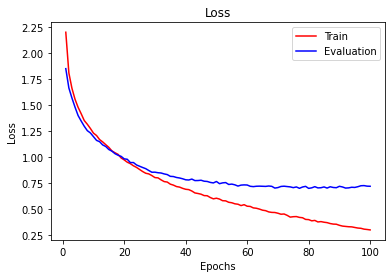

Text(0.5, 1.0, 'Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Acc')

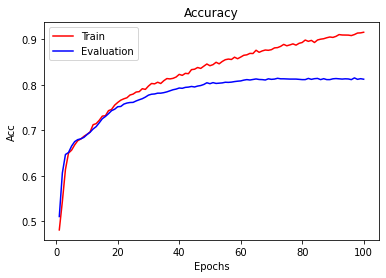

In [115]:
epochs = range(1, len(history['train_loss']) + 1)

plt.plot(epochs, history['train_loss'], 'r-', label='Train')
plt.plot(epochs, history['test_loss'], 'b-', label='Evaluation')

plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, history['train_acc'], 'r-', label='Train')
plt.plot(epochs, history['test_acc'], 'b-', label='Evaluation')

plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

### Accuracy analysis

It's a common practice to use pretrained word vectors to initialize the embedding layer paramters and then fine tune (or freeze) the embedding layer during model training.

- Train word vector by yourself or find pretrained word vectors
- Initialize the embedding layer with the word vectors
- You can freeze the embedding layer or fine tune the layer
- Fit the model to see what strategy can further improve the training performance
- You're expected to show at least 1% improvement from Q2.3. in terms of test accuracy.
 

After several iteration with following details I have made the following analysis 

- The accuracy of the model before using any pretained word vecotrs is as follows
  - embedding_dim = 200, 
  - doc len = 500 : 
  - Epoch = 100 
  - train loss : 0.26517 train_acc : 0.91054, valid loss : 0.80211 **valid acc : 0.79948** 

- I used pretrained word vector 
  - embedding_dim = 200, 
  - doc len = 500 : 
  - Epoch = 100 
  - train loss : 0.30045 train_acc : 0.91545, valid loss : 0.72069 **valid acc : 0.81221**

With pretrained embedding layer the accuracy was increased by **1.273%**